In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

1. Выберите произвольное начальное состояние ("sunny", "cloudy" или "rainy") и смоделируйте 20000 последующих состояний в цепи Маркова с введенной выше матрицей переходов. Результат моделирования (массив размера 20000) запишите в переменную states

In [7]:
state_weather = ("sunny", "cloudy", "rainy")
transition_matrix = np.array(((0.6, 0.3, 0.1),
                              (0.3, 0.4, 0.3),
                              (0.2, 0.3, 0.5)))
vector_state = np.zeros(20_000*3).reshape(20_000, 3)

vector_state[0][np.random.randint(0,3)] = 1

days = 20_000
states = ['' for _ in range(days)]
state_nums = [0]*days
u = np.random.uniform(0, 1, days)
for i in range(1, days):
    vector_state[i] = vector_state[i-1].dot(transition_matrix)
    if u[i] < vector_state[i][0]:
        state_nums[i] = 0
    elif u[i] < vector_state[i][0] + vector_state[i][1]:
        state_nums[i] = 1
    else:
        state_nums[i] = 2
for j in range(days):
    states[j] = state_weather[state_nums[j]]
print(states[:15])

['sunny', 'rainy', 'rainy', 'cloudy', 'cloudy', 'sunny', 'sunny', 'cloudy', 'cloudy', 'sunny', 'sunny', 'rainy', 'cloudy', 'sunny', 'sunny']


2. На основе массива states рассчитайте, как меняется частота встречаемости каждого из типов погоды в массиве states[:n] для n, возрастающих от 1 до 20000. На одном рисунке покажите 3 графика: по оси х откладывайте n, по у - частоту для каждого из трех типов погоды.

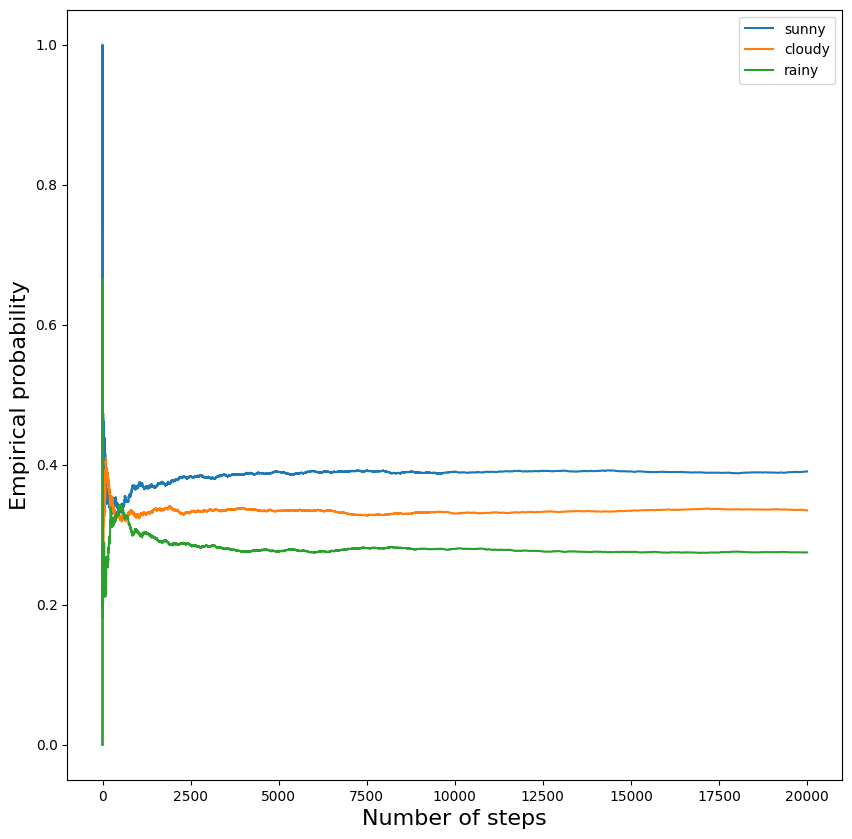

In [21]:
x_points = np.arange(days)
y_points = [[0 for _ in range(days)] for _ in range(3)]
for j in range(0, 3):
    for i in range(1, days):
        y_points[j][i] = state_nums[:i].count(j)/i

fig, ax = plt.subplots(figsize=(10, 10))
plt.xlabel('Number of steps', fontsize = 16)
plt.ylabel('Empirical probability', fontsize = 16, rotation = 90)
for k in range(3):
    plt.plot(x_points, y_points[k])
plt.legend(labels = state_weather)
plt.show()

3. Как следует из картинки, частоты сходятся к некоторым стационарным значениям. Убедитесь, что эти значения совпадают с решением уравнения на стационарную плотность πP=π, где P - это матрица переходных вероятностей, а вектор π - искомая стационарная плотность. Дополнительно убедитесь, это этот же вектор возникает в строках матрицы P, при возведении ее во все большие степени.

In [45]:
# через метод с собственными значениями
eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
stationary_distribution = np.real(eigenvectors[:, np.isclose(eigenvalues, 1)])
stationary_distribution /= np.sum(stationary_distribution)

print(f'Stationary distribution is {stationary_distribution.transpose()[0]}')

X = [y_points[0][-1], y_points[1][-1], y_points[2][-1]]
print(f'After 20_000 days empirical probabilities are {X}')
print("Powers of transition matrix: ")
for n in range(2, 18, 5):
    print(f"Power = {n}:")
    print(np.linalg.matrix_power(transition_matrix, n))
    print("")

Stationary distribution is [0.38888889 0.33333333 0.27777778]
After 20_000 days empirical probabilities are [0.39036951847592377, 0.33491674583729186, 0.27471373568678437]
Powers of transition matrix: 
Power = 2:
[[0.47 0.33 0.2 ]
 [0.36 0.34 0.3 ]
 [0.31 0.33 0.36]]

Power = 7:
[[0.3897081 0.3333333 0.2769586]
 [0.3886158 0.3333334 0.2780508]
 [0.3880697 0.3333333 0.278597 ]]

Power = 12:
[[0.38889728 0.33333333 0.27776939]
 [0.38888609 0.33333333 0.27778057]
 [0.3888805  0.33333333 0.27778617]]

Power = 17:
[[0.38888897 0.33333333 0.27777769]
 [0.38888886 0.33333333 0.27777781]
 [0.3888888  0.33333333 0.27777786]]



5. Методом Метрополиса — Гастингса постройте выборку из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей B = [[40, -26], [-26, 25]]. Сравните плоность по выборке (двумерную гистограмму) и теоретическую плотность.

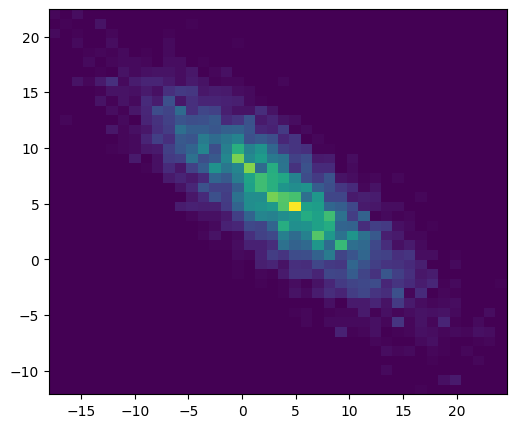

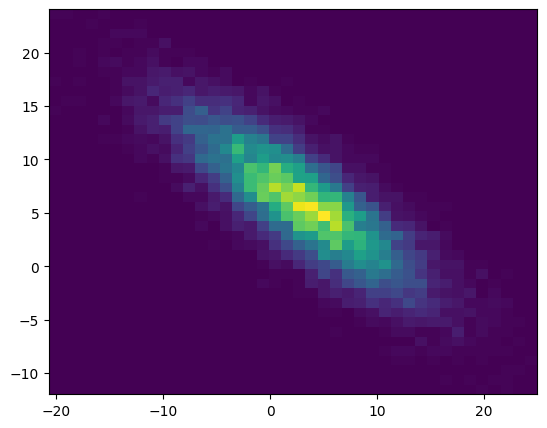

In [4]:
def metroplis(start, value, proposal, niter, nburn=0, **kwargs): 
    '''Generic Metropolis scheme.

    Parameters
    ---
    start : misc
        Initial guess.
    value : callable
        Function to calculate density at given point.
    proposal : callable
        Function to get suggestion on a new point based on a current one.
    niter : int
        Number of iterations.
    nburn : int
        Number of initial samples to be skipped.
    kwargs : dict
        Keywords to be passed in value and proposal.

    Return
    ---
    post : list
        List of samples obtained.
    '''
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current, **kwargs)
        p = value(proposed, **kwargs) / value(current, **kwargs)
        if np.random.rand() < p:
            current = proposed
        post.append([current[0], current[1]])
    return post[nburn:]
# просто значение плотности
def value(point, sred, disp):
    var = multivariate_normal(mean=sred, cov=disp)
    return var.pdf(point)
# новое состояние в алгоритме
def proposal(current, disp, **kwargs):
    _ = kwargs
    current = np.asarray(current)
    disp = np.asarray(disp)
    A = np.linalg.cholesky(disp)
    return current + A @ np.random.randn(*current.shape)

# обобщение изложенного на семинаре до 2-х размерностей

mean = np.array([3,6])
srr = ([[3],[6]])
disp = np.array([[40, -26], [-26, 25]]) # 
A = np.linalg.cholesky(disp) # из предыдущего д/з, про эллипсы
post = metroplis([0,0], value, proposal, 10000, nburn=0, sred = mean, disp = disp)
samples = A @ np.random.randn(2, 10000) + srr 
postarr = np.array(post)
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.hist2d(postarr[:, 0], postarr[:, 1], bins=40)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
h, x, y, _ = ax.hist2d(*samples, bins=40)
ax.set_aspect('equal')

plt.show()

6. Решите задачу 5 методом cэмплирования по Гиббсу.

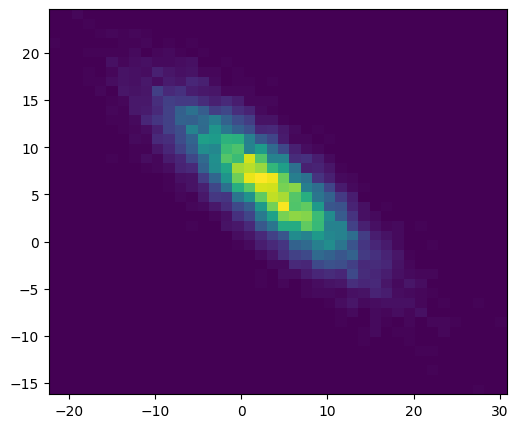

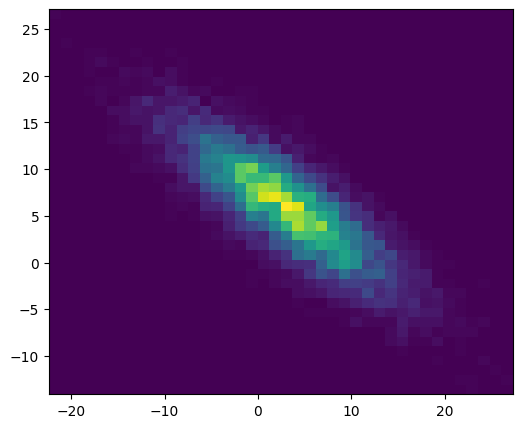

In [8]:
def sampling(beg, d):
    sample = []
    sample.append(beg)
    for i in range (1, d):
        y = np.random.normal(6 - (26/40)*(sample[i-1][0]-3), np.sqrt(25 - 26**2/40))
        x = np.random.normal(3 - (26/25)*(y-6), np.sqrt(40 - 26**2/25))
        elem = [x, y]
        sample.append(elem)
    return sample

mean = np.array([3,6])
srr = ([[3],[6]])
disp = np.array([[40, -26], [-26, 25]])
A = np.linalg.cholesky(di)
I = sampling([0,0],10000)
samples = A @ np.random.randn(2, 10000) + srr 

postarr = np.array(I)
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.hist2d(postarr[:, 0], postarr[:, 1], bins=40)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
h, x, y, _ = ax.hist2d(*samples, bins=40)
ax.set_aspect('equal')

plt.show()

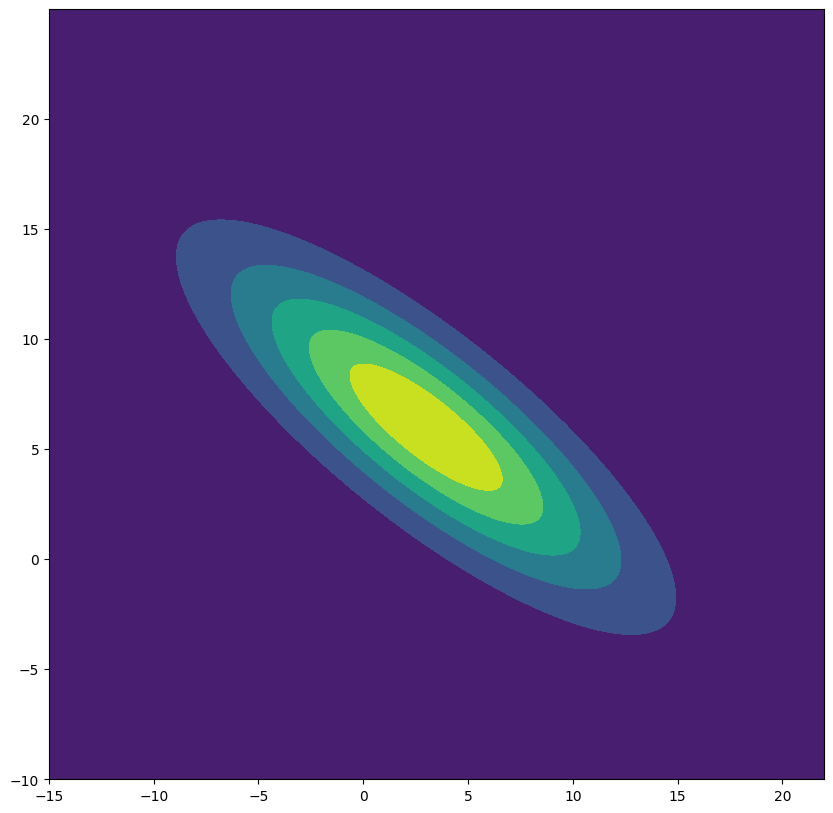

In [69]:
# теоретическое распределение

B = np.array([[40, -26], [-26, 25]])
M = np.array([3, 6])

x, y = np.mgrid[-15:22:.01, -10:25:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(M, B)
fig = plt.figure(figsize=(10, 10))
ax2 = fig.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))
plt.show()